For a full explanation of the code, visit http://ataspinar.com/2017/12/04/using-convolutional-neural-networks-to-detect-features-in-sattelite-images/

In [1]:
import sys
sys.path.insert(0,'..')

import os
import json
import pickle
import requests
import shutil
import random
import numpy as np

from collections import defaultdict
from scipy import ndimage
from datetime import date
from datetime import datetime

import matplotlib.pyplot as plt

#We are using owslib to download images from a WMS Service
#install with 'pip install owslib'
from owslib.wms import WebMapService

#pyshp is necessary for loading and saving shapefiles
#install with 'pip install pyshp'
import shapefile

# Install opencv with 'pip install opencv-python'
import cv2

In [2]:
x_min = 90000
y_min = 427000
dx, dy = 200, 200
no_tiles_x = 100
no_tiles_y = 100
total_no_tiles = no_tiles_x * no_tiles_y

x_max = x_min + no_tiles_x * dx
y_max = y_min + no_tiles_y * dy
bounding_box = [x_min, y_min, x_max, y_max]

TILE_FOLDER = "../datasets/image_tiles_200/"
URL_TILES = "https://geodata.nationaalgeoregister.nl/luchtfoto/rgb/wms?request=GetCapabilities"

URL_SHP = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.shp'
URL_PRF = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.prj'
URL_DBF = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.dbf'
URL_SHX = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.shx'

URLS_SHAPEFILES = [URL_SHP, URL_PRF, URL_DBF, URL_SHX]

DATA_FOLDER = "../data/nwb_wegvakken/"

json_filename = DATA_FOLDER + '2017_09_wegvakken.json'

# 1. Downloading the image tiles

In [3]:
wms = WebMapService(URL_TILES, version='1.1.1')

if not os.path.exists(TILE_FOLDER):
    os.makedirs(TILE_FOLDER)

for ii in range(25,no_tiles_x):
    print(ii)
    for jj in range(0,no_tiles_y):
        ll_x_ = x_min + ii*dx
        ll_y_ = y_min + jj*dy
        bbox = (ll_x_, ll_y_, ll_x_ + dx, ll_y_ + dy) 
        img = wms.getmap(layers=['Actueel_ortho25'], srs='EPSG:28992', bbox=bbox, size=(256, 256), format='image/jpeg', transparent=True)
        filename = "{}{}_{}_{}_{}.jpg".format(TILE_FOLDER, bbox[0], bbox[1], bbox[2], bbox[3])
        out = open(filename, 'wb')
        out.write(img.read())
        out.close()


## 1b. Downloading the shapefiles

In [4]:
if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)

for url in URLS_SHAPEFILES:
    filename = url.split('/')[-1]
    print("Downloading file {}".format(filename))
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(DATA_FOLDER + filename, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)     

# 2. Loading shapefile and converting to (GEO)Json

In [ ]:
def json_serial(obj):
    """JSON serializer for objects not serializable by default json code"""

    if isinstance(obj, (datetime, date)):
        serial = obj.isoformat()
        return serial
    if isinstance(obj, bytes):
        return {'__class__': 'bytes',
                '__value__': list(obj)}
    raise TypeError ("Type %s not serializable" % type(obj))

reader = shapefile.Reader(DATA_FOLDER + 'Wegvakken.shp')
fields = reader.fields[1:]
field_names = [field[0] for field in fields]

buffer = []
for sr in reader.shapeRecords()[:500000]:
    atr = dict(zip(field_names, sr.record))
    geom = sr.shape.__geo_interface__
    buffer.append(dict(type="Feature", geometry=geom, properties=atr)) 


json_file = open(json_filename, "w")
json_file.write(json.dumps({"type": "FeatureCollection", "features": buffer}, indent=2, default=json_serial) + "\n")
json_file.close()

# 3. Declaring some variables and methods

In [7]:
dict_roadtype = {
    "G": 'Gemeente',
    "R": 'Rijk',
    "P": 'Provincie',
    "W": 'Waterschap',
    'T': 'Andere wegbeheerder',
    '' : 'leeg'
}

dict_roadtype_to_color = {
    "G": 'red',
    "R": 'blue',
    "P": 'green',
    "W": 'magenta',
    'T': 'yellow',
    '' : 'leeg'
}

FEATURES_KEY = 'features'
PROPERTIES_KEY = 'properties'
GEOMETRY_KEY = 'geometry'
COORDINATES_KEY = 'coordinates'
WEGSOORT_KEY = 'WEGBEHSRT'

MINIMUM_NO_POINTS_PER_TILE = 4
POINTS_PER_METER = 0.1

INPUT_FOLDER_TILES = './data/image_tiles_200/'

In [8]:
def add_to_dict(d1, d2, coordinates, rtype):
    coordinate_ll_x = int((coordinates[0] // dx)*dx)
    coordinate_ll_y = int((coordinates[1] // dy)*dy)
    coordinate_ur_x = int((coordinates[0] // dx)*dx + dx)
    coordinate_ur_y = int((coordinates[1] // dy)*dy + dy)
    tile = "{}_{}_{}_{}.jpg".format(coordinate_ll_x, coordinate_ll_y, coordinate_ur_x, coordinate_ur_y)
    
    rel_coord_x = (coordinates[0] - coordinate_ll_x) / dx
    rel_coord_y = (coordinates[1] - coordinate_ll_y) / dy
    value = (rtype, rel_coord_x, rel_coord_y)
    d1[tile].append(value)
    d2[rtype].add(tile)

def coord_is_in_bb(coord, bb):
    x_min = bb[0]
    y_min = bb[1]
    x_max = bb[2]
    y_max = bb[3]
    return coord[0] > x_min and coord[0] < x_max and coord[1] > y_min and coord[1] < y_max

def retrieve_roadtype(elem):
    return elem[PROPERTIES_KEY][WEGSOORT_KEY]
   
def retrieve_coordinates(elem):
    return elem[GEOMETRY_KEY][COORDINATES_KEY]

def eucledian_distance(p1, p2):
    diff = np.array(p2)-np.array(p1)
    return np.linalg.norm(diff)

def calculate_intermediate_points(p1, p2, no_points):
    dx = (p2[0] - p1[0]) / (no_points + 1)
    dy = (p2[1] - p1[1]) / (no_points + 1)
    return [[p1[0] + i * dx, p1[1] +  i * dy] for i in range(1, no_points+1)]



# 4. Map contents of shapefile to the tiles

In [9]:
filename_wegvakken = json_filename
dict_wegvakken = json.load(open(filename_wegvakken))[FEATURES_KEY]

In [10]:
d_tile_contents = defaultdict(list)
d_roadtype_tiles = defaultdict(set)
    
for elem in dict_wegvakken:
    coordinates = retrieve_coordinates(elem)
    rtype = retrieve_roadtype(elem)
    coordinates_in_bb = [coord for coord in coordinates if coord_is_in_bb(coord, bounding_box)]
    if len(coordinates_in_bb)==1:
        coord = coordinates_in_bb[0]
        add_to_dict(d_tile_contents, d_roadtype_tiles, coord, rtype)
    if len(coordinates_in_bb)>1:
        add_to_dict(d_tile_contents, d_roadtype_tiles, coordinates_in_bb[0], rtype)
        for ii in range(1,len(coordinates_in_bb)):
            previous_coord = coordinates_in_bb[ii-1]
            coord = coordinates_in_bb[ii]
            add_to_dict(d_tile_contents, d_roadtype_tiles, coord, rtype)
            
            dist = eucledian_distance(previous_coord, coord)
            no_intermediate_points = int(dist*POINTS_PER_METER)           
            intermediate_coordinates = calculate_intermediate_points(previous_coord, coord, no_intermediate_points)
            for intermediate_coord in intermediate_coordinates:
                add_to_dict(d_tile_contents, d_roadtype_tiles, intermediate_coord, rtype)


# 4b. Visualize results

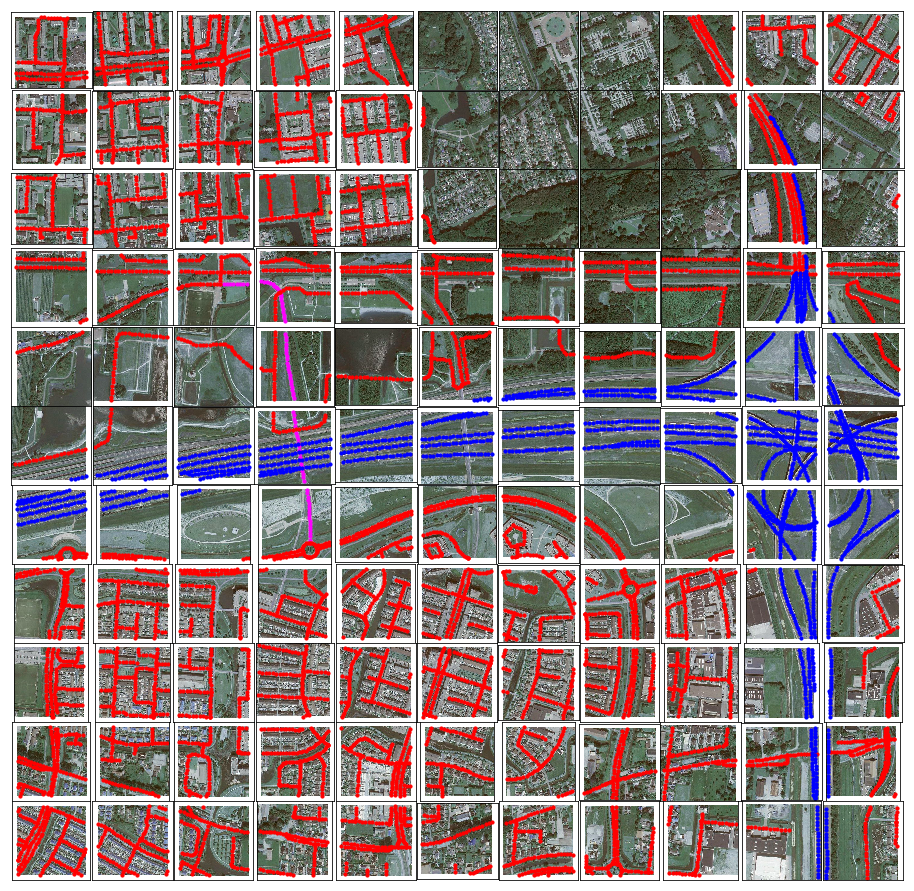

In [9]:
x0 = 93000
y0 = 430000

fig, axarr = plt.subplots(nrows=11,ncols=11, figsize=(16,16))

for ii in range(0,11):
    for jj in range(0,11):
        ll_x = x0 + ii*dx
        ll_y = y0 + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = INPUT_FOLDER_TILES + tile
        tile_contents = d_tile_contents[tile]
        
        ax = axarr[10-jj, ii]
        image = ndimage.imread(filename)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(rgb_image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        for elem in tile_contents:
            color = dict_roadtype_to_color[elem[0]]
            x = elem[1]*256
            y = (1-elem[2])*256
            ax.scatter(x,y,c=color,s=10)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

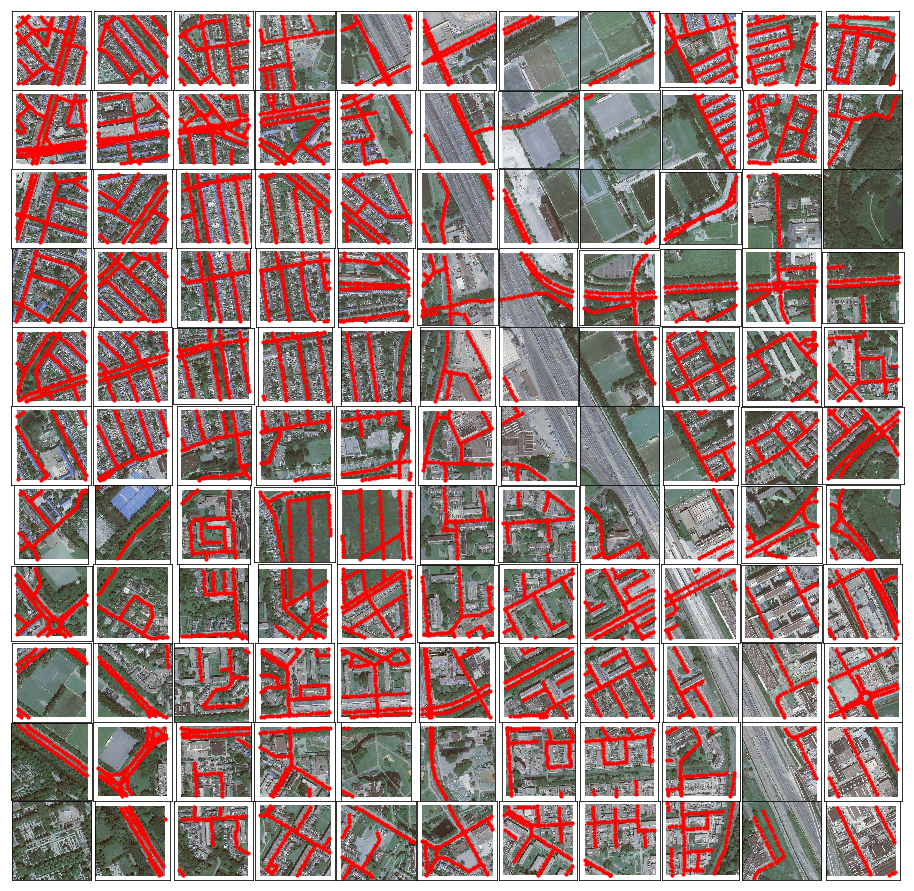

In [10]:
x0 = 94400
y0 = 432000
POINTS_PER_METER = 0

fig, axarr = plt.subplots(nrows=11,ncols=11, figsize=(16,16))

for ii in range(0,11):
    for jj in range(0,11):
        ll_x = x0 + ii*dx
        ll_y = y0 + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = INPUT_FOLDER_TILES + tile
        tile_contents = d_tile_contents[tile]
        
        ax = axarr[10-jj, ii]
        image = ndimage.imread(filename)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(rgb_image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        for elem in tile_contents:
            color = dict_roadtype_to_color[elem[0]]
            x = elem[1]*256
            y = (1-elem[2])*256
            ax.scatter(x,y,c=color,s=10)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# 4c. Some statistics about the dataset

In [11]:
print("There are {} tiles containing roads.".format(len(d_tile_contents.keys())))

for rtype in d_roadtype_tiles.keys():
    roadtype = dict_roadtype[rtype]
    no_tiles = len(d_roadtype_tiles[rtype])
    print("Of roadtype {} ({}) there are {} tiles.".format(rtype, roadtype, no_tiles))

There are 4069 tiles containing roads.
Of roadtype G (Gemeente) there are 2903 tiles.
Of roadtype W (Waterschap) there are 820 tiles.
Of roadtype P (Provincie) there are 8 tiles.
Of roadtype R (Rijk) there are 470 tiles.


# 5. Prepare dataset for CNN

In [12]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

def onehot_encode_labels(labels):
    list_possible_labels = list(np.unique(labels))
    encoded_labels = map(lambda x: list_possible_labels.index(x), labels)
    return encoded_labels

def randomize(dataset, labels1, labels2, labels3):
    permutation = np.random.permutation(dataset.shape[0])
    randomized_dataset = dataset[permutation, :, :, :]
    randomized_labels1 = labels1[permutation]
    randomized_labels2 = labels2[permutation]
    randomized_labels3 = labels3[permutation]
    return randomized_dataset, randomized_labels1, randomized_labels2, randomized_labels3

def one_hot_encode(np_array, num_unique_labels):
    return (np.arange(num_unique_labels) == np_array[:,None]).astype(np.float32)

def reformat_data(dataset, labels1, labels2, labels3):
    dataset, labels1, labels2, labels3 = randomize(dataset, labels1, labels2, labels3)
    num_unique_labels1 = len(np.unique(labels1))
    num_unique_labels2 = len(np.unique(labels2))
    labels1 = one_hot_encode(labels1, num_unique_labels1)
    labels2 = one_hot_encode(labels2, num_unique_labels2)
    return dataset, labels1, labels2, labels3

In [13]:
image_width = 256
image_height = 256
image_depth = 3
total_no_images = 10000

image_files = os.listdir(INPUT_FOLDER_TILES)

dataset = np.ndarray(shape=(total_no_images, image_width, image_height, image_depth), dtype=np.float32)
labels_roadtype = []
labels_roadpresence = np.ndarray(total_no_images, dtype=np.float32)
labels_filename = []

for counter, image in enumerate(image_files):
    filename = INPUT_FOLDER_TILES + image
    labels_filename.append(image)
    if image in list(d_tile_contents.keys()):
        tile_contents = d_tile_contents[image]
        roadtypes = sorted(list(set([elem[0] for elem in tile_contents])))
        roadtype = "_".join(roadtypes)
        labels_roadpresence[counter] = 1
    else:
        roadtype = ''
        labels_roadpresence[counter] = 0
    labels_roadtype.append(roadtype)

    image_data = ndimage.imread(filename).astype(np.float32)
    dataset[counter, :, :] = image_data
    if counter % 1000 == 0:
        print("{} images have been loaded.".format(counter))


0 images have been loaded.
1000 images have been loaded.
2000 images have been loaded.
3000 images have been loaded.
4000 images have been loaded.
5000 images have been loaded.
6000 images have been loaded.
7000 images have been loaded.
8000 images have been loaded.
9000 images have been loaded.


In [14]:
labels_filename = np.array(labels_filename)
labels_roadtype_ohe = np.array(list(onehot_encode_labels(labels_roadtype)))
print("Randomizing dataset...")
dataset, labels_roadpresence, labels_roadtype_ohe, labels_filename = reformat_data(dataset, labels_roadpresence, labels_roadtype_ohe, labels_filename)

Randomizing dataset...


In [15]:
start_train_dataset = 0
start_valid_dataset = 1200
start_test_dataset = 1600
total_no_images = 2000

output_pickle_file = './data/sattelite_dataset.pickle'

f = open(output_pickle_file, 'wb')
save = {
'train_dataset': dataset[start_train_dataset:start_valid_dataset,:,:,:],
'train_labels_roadtype': labels_roadtype[start_train_dataset:start_valid_dataset],
'train_labels_roadpresence': labels_roadpresence[start_train_dataset:start_valid_dataset],
'train_labels_filename': labels_filename[start_train_dataset:start_valid_dataset],
'valid_dataset': dataset[start_valid_dataset:start_test_dataset,:,:,:],
'valid_labels_roadtype': labels_roadtype[start_valid_dataset:start_test_dataset],
'valid_labels_roadpresence': labels_roadpresence[start_valid_dataset:start_test_dataset],
'valid_labels_filename': labels_filename[start_valid_dataset:start_test_dataset],
'test_dataset': dataset[start_test_dataset:total_no_images,:,:,:],
'test_labels_roadtype': labels_roadtype[start_test_dataset:total_no_images],
'test_labels_roadpresence': labels_roadpresence[start_test_dataset:total_no_images],
'test_labels_filename': labels_filename[start_test_dataset:total_no_images]
}
pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
f.close()

print("\nsaved dataset to {}".format(output_pickle_file))


saved dataset to sattelite_dataset_new_200.pickle


# 6. The Convolutional neural network part

In [16]:
import tensorflow as tf
from cnn_models.vggnet16 import * 

In [17]:
pickle_file = './data/sattelite_dataset.pickle'
f = open(pickle_file, 'rb')
save = pickle.load(f)

train_dataset = save['train_dataset'].astype(dtype = np.float32)
train_labels = save['train_labels_roadpresence'].astype(dtype = np.float32)
valid_dataset = save['valid_dataset'].astype(dtype = np.float32)
valid_labels = save['valid_labels_roadpresence'].astype(dtype = np.float32)
test_dataset = save['test_dataset'].astype(dtype = np.float32)
test_labels = save['test_labels_roadpresence'].astype(dtype = np.float32)

f.close()

In [18]:
num_labels = len(np.unique(train_labels))
image_width = 256
image_height = 256
image_depth = 3
num_steps = 501
display_step = 10
learning_rate = 0.0001
batch_size = 16
lambda_loss_amount = 0.0015

In [19]:
train_accuracies, test_accuracies, valid_accuracies = [], [], []
 
print("STARTING WITH SATTELITE")
graph = tf.Graph()
with graph.as_default():
    #1) First we put the input data in a tensorflow friendly form. 
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_width, image_height, image_depth))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_test_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_width, image_height, image_depth))
    tf_test_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
    tf_valid_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_width, image_height, image_depth))
    tf_valid_labels = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
 
    #2) Then, the weight matrices and bias vectors are initialized
    variables = variables_vggnet16()
 
    #3. The model used to calculate the logits (predicted labels)
    model = model_vggnet16
    
    logits = model(tf_train_dataset, variables)
 
    #4. then we compute the softmax cross entropy between the logits and the (actual) labels
    l2 = lambda_loss_amount * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + l2
 
    #learning_rate = tf.train.exponential_decay(0.05, global_step, 1000, 0.85, staircase=True)
    #5. The optimizer is used to calculate the gradients of the loss function 
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
 
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    test_prediction = tf.nn.softmax(model(tf_test_dataset, variables))
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, variables))
 
 
with tf.Session(graph=graph) as session:
    test_counter = 0
    tf.global_variables_initializer().run()
    print('Initialized with learning_rate', learning_rate, " model ", ii)
    for step in range(num_steps):
        #Since we are using stochastic gradient descent, we are selecting  small batches from the training dataset,
        #and training the convolutional neural network each time with a batch. 
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :,  :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        train_accuracy = accuracy(predictions, batch_labels)
        train_accuracies.append(train_accuracy)
 
        if step % display_step == 0:
            offset2 = (test_counter * batch_size) % (test_labels.shape[0] - batch_size)
            test_dataset_batch = test_dataset[offset2:(offset2 + batch_size), :, :]
            test_labels_batch = test_labels[offset2:(offset2 + batch_size), :]
            feed_dict2 = {tf_test_dataset : test_dataset_batch, tf_test_labels : test_labels_batch}
            
            test_prediction_ = session.run(test_prediction, feed_dict=feed_dict2)
            test_accuracy = accuracy(test_prediction_, test_labels_batch)
            test_accuracies.append(test_accuracy)
 
            valid_dataset_batch = valid_dataset[offset2:(offset2 + batch_size), :, :]
            valid_labels_batch = valid_labels[offset2:(offset2 + batch_size), :]
            feed_dict3 = {tf_valid_dataset : valid_dataset_batch, tf_valid_labels : valid_labels_batch}
            
            valid_prediction_ = session.run(valid_prediction, feed_dict=feed_dict3)
            valid_accuracy = accuracy(valid_prediction_, valid_labels_batch)
            valid_accuracies.append(valid_accuracy)
 
            message = "step {:04d} : loss is {:06.2f}, accuracy on training set {:02.2f} %, accuracy on test set {:02.2f} accuracy on valid set {:02.2f} %".format(step, l, train_accuracy, test_accuracy, valid_accuracy)
            print(message)

# Visualizing Accuracies

In [20]:
def average_points(points, stepsize = 10):
    averaged_points = []
    for ii in range(stepsize,len(points),stepsize):
        subsection  = points[ii-stepsize:ii]
        average = np.nanmean(subsection)
        averaged_points.append(average)
    return averaged_points

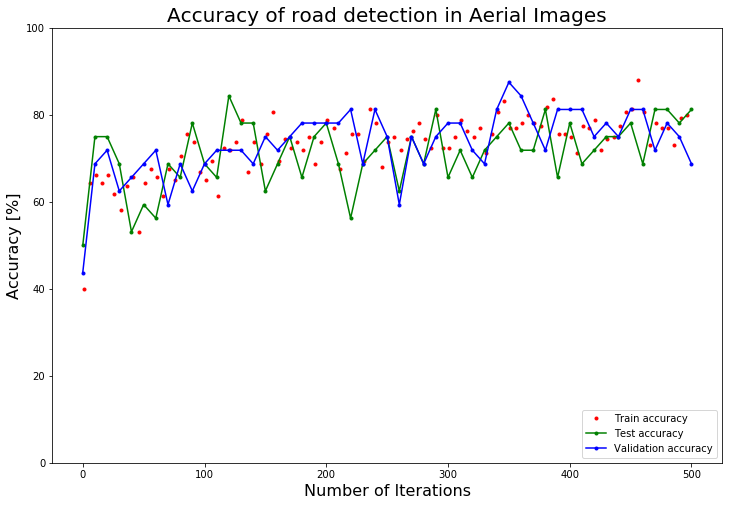

In [21]:
num_steps = 501
ylimit = [0,100]
labels = ['Train accuracy', 'Test accuracy', 'Validation accuracy']
ylabel = "Accuracy [%]"
xlabel = "Number of Iterations"
title = "Accuracy of road detection in Aerial Images"
colors = ['r', 'g', 'b']

list_accuracies = [train_accuracies, test_accuracies, valid_accuracies]

fig, ax = plt.subplots(figsize=(12,8))
ax.set_ylim(ylimit)
ax.set_ylabel(ylabel, fontsize=16)
ax.set_xlabel(xlabel, fontsize=16)
ax.set_title(title, fontsize=20)


for ii, accuracies in enumerate(list_accuracies):
    color = colors[ii]
    label = labels[ii]
    if ii > 0:
        y_values = accuracies
        x_values = range(0,num_steps, 10)
        ax.plot(x_values, y_values, '.-{}'.format(color), label = label)
    else:
        y_values_ = accuracies
        y_values = average_points(y_values_, 5)
        x_values = range(1,len(y_values_),5)
        ax.plot(x_values, y_values, '.{}'.format(color), label = label)
ax.legend(loc='lower right')
plt.show()